<h3>Natural Language Processing

<h4>Traditional NLP:

<h5>Sentiment Analysis

In [1]:
# Determining whether a tweet has a positive/negative sentiment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_tweets = pd.read_csv("twitter_training.csv")
raw_tweets.head()

,id,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
raw_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             198 non-null    int64 
 1   entity         198 non-null    object
 2   sentiment      198 non-null    object
 3   Tweet content  198 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.3+ KB


In [5]:
raw_tweets.isnull().sum()

id               0
entity           0
sentiment        0
Tweet content    0
dtype: int64

Pre-processing:

In [6]:
# Steps required to get from text to an input format:

# 1) Cleaning + normalization (remove noise that adds variance but not meaning).

# 2) Tokenize the text i.e. split it up into 'units'.

# 3) Normalisation e.g stopword removeal (the, is, and etc), stemming (reduce words to root form), and
#       lemmatization (reduce words to dictionary form).

# 4) Vectorization/Encoding: text -> numbers (e.g TF-IDF vectorizer).

In [7]:
#1) Cleaning:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    try:
        text = str(text) 
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) #Remove IRLs
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text) #Remove special punctuationa and characters
        text = text.lower() #Lowercase
        text = re.sub(r'\d+', '', text) #Remove numbers
        text = ' '.join(text.split()) # Remove unnecessary whitespace
        return text
    except Exception as e:
        print(f"Error: {e}")
        return ""

In [8]:
test_tweet = raw_tweets["Tweet content"][20]
test_tweet

'The biggest disappointment of my life came a year ago.'

In [9]:
cleaned_test_tweet = clean_text(test_tweet)
cleaned_test_tweet
# The capital letters and the full stop were removed.

'the biggest disappointment of my life came a year ago'

In [10]:
# 2) and 3) Tokenize and lemmatize:
import nltk
from nltk.stem import WordNetLemmatizer #reduce words to dictionary form
from nltk.corpus import stopwords

# Allows the lemmatizer to have access to certain words (and their behaviour when encountered):
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [11]:
lemm = WordNetLemmatizer()
stop_words =  set(stopwords.words('english'))

def process_text(text):
    try:
        text = clean_text(text)
        if not text.strip(): #If removing the whitespace returns no text i.e. there was no text in the first space...
            return "" # ...keep it blank

        tokens = [lemm.lemmatize(word) for word in text.split() if word not in stop_words and len(word) > 2] #Tokenize
        return ' '.join(tokens), tokens #Join the tokens back up (and returns tokens for confirmation)
        

    except Exception as e:
        print(f"Error: {e}")
        return ""

In [12]:
processed_test_tweet, test_tweet_tokens = process_text(test_tweet)
print(processed_test_tweet)
print(test_tweet_tokens)
# See how it tokenized the tweet:

biggest disappointment life came year ago
['biggest', 'disappointment', 'life', 'came', 'year', 'ago']


In [13]:
# Re-define

def process_text(text):
    try:
        text = clean_text(text)
        if not text.strip(): 
            return "" # 

        tokens = [lemm.lemmatize(word) for word in text.split() if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
        

    except Exception as e:
        print(f"Error: {e}")
        return ""

In [14]:
tweets=raw_tweets

In [15]:
# Apply preprocessing:
tweets['cleaned_text'] = tweets['Tweet content'].apply(process_text)
tweets.head()

,id,entity,sentiment,Tweet content,cleaned_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder


In [16]:
# Some of the 'cleaned_text' entries may be blank after preprocessing. Make sure to remove them:
dropped_rows = 0
for idx in list(tweets.index):
    if tweets.at[idx, 'cleaned_text'].strip() == '':
        tweets = tweets.drop(idx)
        dropped_rows += 1

print(dropped_rows)
tweets.head()

3


,id,entity,sentiment,Tweet content,cleaned_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder


In [17]:
# 3 of the cleaned_text rows were empty and therefore removed.

In [18]:
# 4) Splitting + Vectorizattion using TF-IDF (similar to scaling):

# Split before vectorization:
from sklearn.model_selection import train_test_split

X = tweets['cleaned_text']
y = tweets['sentiment'].astype(str)  # Ensure sentiment is string type
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, stratify=y # implement the class imbalance
)

# Vectorize:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Include bigrams
    min_df=5,            # Ignore terms that appear in fewer than 5 documents
    max_df=0.7           # Ignore terms that appear in more than 70% of documents
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) # Don't do 'fit' on the test set!
X_test_tfidf = tfidf_vectorizer.transform(X_test) # Only transform on the test.

In [19]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1281 stored elements and shape (156, 170)>

In [20]:
X_test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 189 stored elements and shape (39, 170)>

In [21]:
# Looks good so far...

Modelling:

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb_sentiment_classifier = MultinomialNB(alpha=0.1)
nb_sentiment_classifier.fit(X_train_tfidf, y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",0.1
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

def evaluate_nb_classifier(model, X_test, y_test, positive_label='Positive', print_report=True):
    """
    Evaluate a trained MultinomialNB classifier.
    Returns a dict with common metrics and prints/plots a short summary when print_report is True.
    """
    X = X_test
    y=y_test
    y_pred = model.predict(X)
    results = {}
    results['accuracy'] = accuracy_score(y, y_pred)
    results['precision_macro'] = precision_score(y, y_pred, average='macro', zero_division=0)
    results['recall_macro'] = recall_score(y, y_pred, average='macro', zero_division=0)
    results['f1_macro'] = f1_score(y, y_pred, average='macro', zero_division=0)

    labels_sorted = sorted(set(y))
    other_label = next((lbl for lbl in labels_sorted if lbl != positive_label), None)
    if other_label is not None:
        cm_labels = [positive_label, other_label]
    else:
        cm_labels = labels_sorted

    results['confusion_matrix'] = confusion_matrix(y, y_pred, labels=cm_labels)
    results['classification_report'] = classification_report(y, y_pred, zero_division=0)

    # ROC AUC, ROC curve and PR curve if probability estimates available and binary
    try:
        if hasattr(model, "predict_proba"):
            classes = list(model.classes_)
            if len(classes) == 2 and positive_label in classes:
                proba = model.predict_proba(X)[:, classes.index(positive_label)]
                mapping = {c: (1 if c == positive_label else 0) for c in classes}
                y_bin = pd.Series(y).map(mapping).astype(int)

                results['roc_auc'] = roc_auc_score(y_bin, proba)

                fpr, tpr, _ = roc_curve(y_bin, proba)
                roc_auc = auc(fpr, tpr)
                results['roc_curve'] = (fpr, tpr, roc_auc)

                precision, recall, _ = precision_recall_curve(y_bin, proba)
                pr_auc = auc(recall, precision)
                results['pr_curve'] = (precision, recall, pr_auc)
    except Exception:
        pass

    if print_report:
        print(f"Accuracy: {results['accuracy']:.4f}  |  F1 (macro): {results['f1_macro']:.4f}")
        if 'roc_auc' in results:
            print(f"ROC AUC: {results['roc_auc']:.4f}")
        print("Confusion matrix:\n", results['confusion_matrix'])
        print("\nClassification report:\n", results['classification_report'])

        # Plot confusion matrix
        plt.figure(figsize=(5,4))
        sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=cm_labels, yticklabels=cm_labels)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()

        # ROC curve
        if 'roc_curve' in results:
            fpr, tpr, roc_auc = results['roc_curve']
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0,1], [0,1], 'k--', alpha=0.6)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc='lower right')
            plt.grid(alpha=0.3)
            plt.show()

        # Precision-Recall curve
        if 'pr_curve' in results:
            precision, recall, pr_auc = results['pr_curve']
            plt.figure(figsize=(6,5))
            plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc='lower left')
            plt.grid(alpha=0.3)
            plt.show()

    return results

Accuracy: 0.8974  |  F1 (macro): 0.8796
ROC AUC: 0.9822
Confusion matrix:
 [[25  1]
 [ 3 10]]

Classification report:
               precision    recall  f1-score   support

    Negative       0.91      0.77      0.83        13
    Positive       0.89      0.96      0.93        26

    accuracy                           0.90        39
   macro avg       0.90      0.87      0.88        39
weighted avg       0.90      0.90      0.90        39



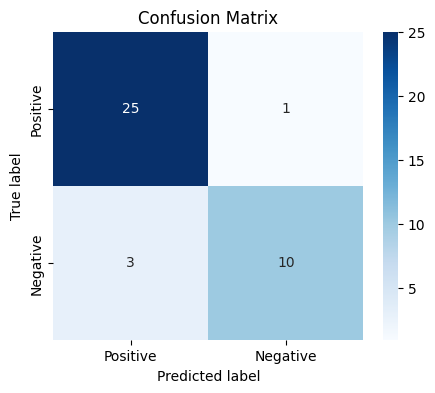

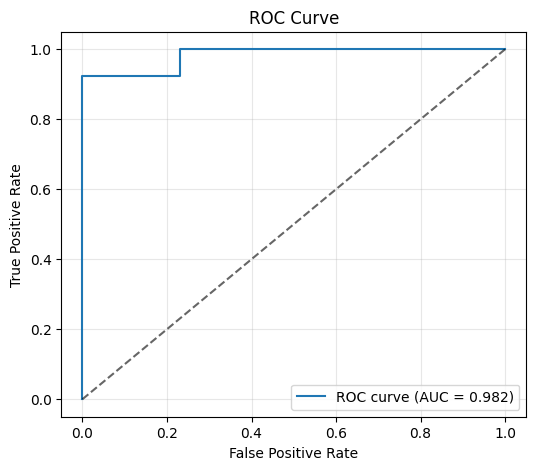

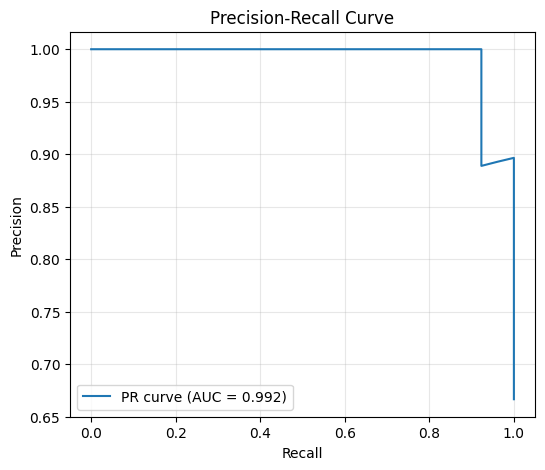

In [24]:
nb_sentiment_evaluation = evaluate_nb_classifier(nb_sentiment_classifier, X_test_tfidf,y_test)

<h5>Topic Modelling:

In [25]:
# We're not doing supervised learning for topic modelling as the topics of each tweet are unlabelled (but sentiment is). We do the modelling
# on the whole dataset with no splitting.

In [26]:
from sklearn.decomposition import NMF

# Vectorize the full preprocessed data (X is the cleaned_text Series with no splitting)
tfidf_topics_vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=2,
    ngram_range=(1, 2)
)

X_tfidf_full = tfidf_topics_vectorizer.fit_transform(X)

nmf = NMF(
    n_components=5,
    random_state=42,
    init="nndsvda",
    max_iter=1000
)
W = nmf.fit_transform(X_tfidf_full)   # doc-topic weights
H = nmf.components_                   # topic-word weights

feature_names = tfidf_topics_vectorizer.get_feature_names_out()

def show_nmf_topics(H, feature_names, n_top_words=10):
    for k, topic in enumerate(H):
        top = topic.argsort()[:-n_top_words-1:-1]
        print(f"Topic {k}: " + ", ".join(feature_names[i] for i in top))

show_nmf_topics(H, feature_names, n_top_words=10)

Topic 0: borderland good, good, omg, good omg, borderland, good far, far, far borderland, fav, borderland fav
Topic 1: bitch, fuck, coming, count, bitch count, bioshock, borderland coming, count fuck, bioshock borderland, coming switch
Topic 2: borderland, fun, stream, end, finally, got, play, closer, playing, probably
Topic 3: really, drop, kill, actually, good kill, session, experience, borderland session, time, mayhem
Topic 4: best, platinum, platinum best, best loot, loot, game, borderland, kind, handsome, borderland best


In [27]:
# Seems a bit inchorent and repetitive between topics. Re-try but remove omit certain words:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

domain_stop = {"borderland", "borderlands", "bl3"}  # Can tweak
stop_words = ENGLISH_STOP_WORDS.union(domain_stop)

tfidf_topics_vectorizer_2 = TfidfVectorizer(
    stop_words=list(stop_words),
    min_df=2,
    ngram_range=(1, 2)
)

X_tfidf_full = tfidf_topics_vectorizer_2.fit_transform(X)

nmf = NMF(
    n_components=5,
    random_state=42,
    init="nndsvda",
    max_iter=1000
)
W = nmf.fit_transform(X_tfidf_full)   # doc-topic weights
H = nmf.components_                   # topic-word weights

feature_names = tfidf_topics_vectorizer_2.get_feature_names_out()

def show_nmf_topics(H, feature_names, n_top_words=10):
    for k, topic in enumerate(H):
        top = topic.argsort()[:-n_top_words-1:-1]
        print(f"Topic {k}: " + ", ".join(feature_names[i] for i in top))

show_nmf_topics(H, feature_names, n_top_words=10)

Topic 0: bitch, fuck, coming, count, bitch count, bioshock, count fuck, bioshock coming, switch, coming switch
Topic 1: omg, good, good omg, good far, far, fav, far fav, favorite, unk, probably
Topic 2: fun, stream, end, play, finally, got, closer, tps, imma, bit
Topic 3: really, drop, kill, actually, experience, session, good kill, mayhem, time, actually really
Topic 4: best, platinum, platinum best, best loot, loot, game, handsome, kind, game okay, okay


In [28]:
# The theme of each topic now seems to be noticeable

<h4>Transformers:

<h5>Sentiment Analysis

In [29]:
# Less preprocessing on our end is required as it is handled mostly by the transformer.

In [30]:
tweets = raw_tweets.drop('cleaned_text', axis=1)
tweets.head()

,id,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Load the transformer:

In [31]:
from transformers import pipeline, DistilBertTokenizer, DistilBertForSequenceClassification
import torch

sentiment_classification = pipeline('sentiment-analysis') #'sentiment-analysis' is a task identifier
type(sentiment_classification)

c:\Users\cochr\Python Virtual Environments\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\cochr\Python Virtual Environments\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cochr\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In

transformers.pipelines.text_classification.TextClassificationPipeline

In [32]:
# Prepare data for the transformer pipeline

# Use original tweet text (less preprocessing required for transformers)
transformer_texts = tweets['Tweet content'].fillna('').astype(str).str.strip().tolist()

# Helper to yield batches (pipeline handles lists; batching avoids memory spikes)
def batchify(items, batch_size=32):
    for i in range(0, len(items), batch_size):
        yield items[i:i+batch_size]

# Run pipeline in batches and attach results back to the dataframe
preds = []
for batch in batchify(transformer_texts, batch_size=32):
    preds.extend(sentiment_classification(batch, truncation=True, padding=True))

tweets['transformer_label'] = [p['label'] for p in preds]
tweets['transformer_score'] = [p.get('score') for p in preds]

# Ready: tweets DataFrame now contains transformer_label and transformer_score

In [33]:
tweets.head()

,id,entity,sentiment,Tweet content,transformer_label,transformer_score
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,NEGATIVE,0.983470
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,POSITIVE,0.993287
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,POSITIVE,0.978374
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,NEGATIVE,0.976876
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,POSITIVE,0.701889


Accuracy: 0.8030  |  F1 (macro): 0.7974
ROC AUC: 0.9421
Confusion matrix:
 [[63  3]
 [36 96]]

Classification report:
               precision    recall  f1-score   support

    Negative       0.64      0.95      0.76        66
    Positive       0.97      0.73      0.83       132

    accuracy                           0.80       198
   macro avg       0.80      0.84      0.80       198
weighted avg       0.86      0.80      0.81       198



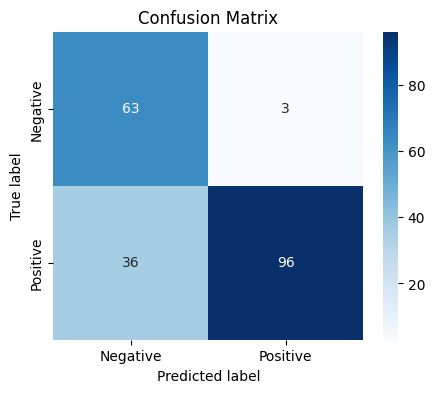

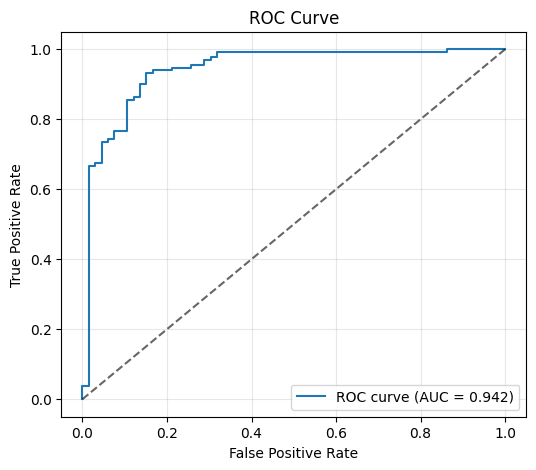

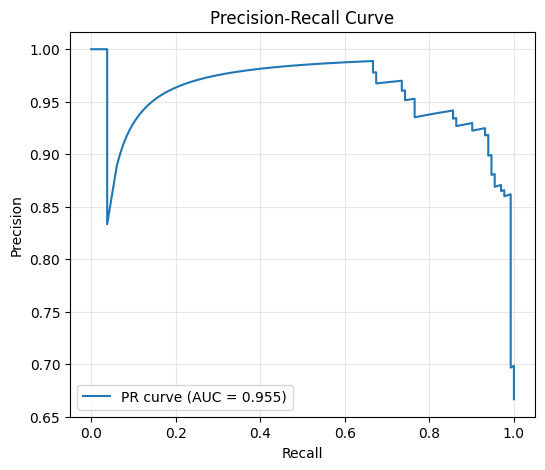

In [35]:
def evaluate_transformer(
    df,
    label_col='sentiment',
    pred_col='transformer_label',
    score_col='transformer_score',
    positive_label='Positive',
    print_report=True
):
    """
    Evaluate transformer predictions in `df` by comparing `label_col` (true labels)
    with `pred_col` (pipeline labels). If `score_col` exists, it's used to compute
    ROC/PR (score is assumed to be the probability of the predicted label from the pipeline).
    Returns a dict of metrics and plotted diagnostics when print_report=True.
    """
    # Prepare true / predicted labels (normalize case)
    y_true = df[label_col].astype(str).str.strip()
    y_pred_raw = df[pred_col].astype(str).str.strip()

    # Normalize transformer labels like 'POSITIVE'/'NEGATIVE' -> 'Positive'/'Negative'
    y_pred = y_pred_raw.str.lower().map({'positive': 'Positive', 'negative': 'Negative'}).fillna(y_pred_raw)

    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    results['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    results['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Confusion matrix and report
    labels_sorted = sorted(set(y_true))
    results['confusion_matrix'] = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    results['classification_report'] = classification_report(y_true, y_pred, zero_division=0)

    # ROC/PR if possible (binary) and score_col present
    if score_col in df.columns and len(set(y_true)) == 2:
        # Build binary true vector (1 for positive_label)
        y_bin = (y_true == positive_label).astype(int)

        scores = df[score_col].astype(float).values

        # The pipeline score is probability of the predicted label.
        # Convert it to probability of the positive class:
        # if predicted == positive_label => prob_positive = score
        # else => prob_positive = 1 - score
        pred_is_pos = (y_pred == positive_label).values
        prob_positive = np.where(pred_is_pos, scores, 1.0 - scores)

        try:
            results['roc_auc'] = roc_auc_score(y_bin, prob_positive)
            fpr, tpr, _ = roc_curve(y_bin, prob_positive)
            results['roc_curve'] = (fpr, tpr, auc(fpr, tpr))

            precision, recall, _ = precision_recall_curve(y_bin, prob_positive)
            results['pr_curve'] = (precision, recall, auc(recall, precision))
        except Exception:
            pass

    if print_report:
        print(f"Accuracy: {results['accuracy']:.4f}  |  F1 (macro): {results['f1_macro']:.4f}")
        if 'roc_auc' in results:
            print(f"ROC AUC: {results['roc_auc']:.4f}")
        print("Confusion matrix:\n", results['confusion_matrix'])
        print("\nClassification report:\n", results['classification_report'])

        # Plot confusion matrix
        plt.figure(figsize=(5,4))
        sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels_sorted, yticklabels=labels_sorted)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()

        # ROC curve
        if 'roc_curve' in results:
            fpr, tpr, roc_auc = results['roc_curve']
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0,1], [0,1], 'k--', alpha=0.6)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc='lower right')
            plt.grid(alpha=0.3)
            plt.show()

        # Precision-Recall curve
        if 'pr_curve' in results:
            precision, recall, pr_auc = results['pr_curve']
            plt.figure(figsize=(6,5))
            plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc='lower left')
            plt.grid(alpha=0.3)
            plt.show()

    return results

transformer_sentiment_results = evaluate_transformer(tweets)

In [36]:
# Not as effective as the NLP model. Is this due to the preprocessing?

<h5>Topic Analysis: